# **New York Times Data: Collection, Processing, Analysis, Visualization**


This Jupyter Notebook carries out the data collection (through web-scraping), cleaning/wrangling, analysis, and visualization tasks for the New York Times (NYT) articles pertaining to the keyword 'abortion' over the time period we are studying. First, we scrape the data using NYT's API, and store it in a desired format. We clean the rows with empty values, rest the index, and prepare the dataframe. Then, we use `nltk` functionalities to carry out a sentiment analysis on this data.

## Libraries

In [88]:
import requests
from bs4 import BeautifulSoup           # web-scraping libraries
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import nltk
nltk.download('stopwords')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime
from dateutil import parser
from nltk.corpus import stopwords
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Data Collection, Cleaning, Wrangling, Pre-Processing

In [71]:

# set the API endpoint and query parameters
url = "https://api.nytimes.com/svc/archive/v1/{year}/{month}.json"
api_key = "lYGrTdxHlkT7QAAIvlJhjsuZdhCYAWhc"
query = "abortion"
start_year = 2022
start_month = 1
end_year = 2023
end_month = 1

# create an empty list to store the lead bodies
lead_bodies = []

# loop over each month and year to get the articles
for year in range(start_year, end_year+1):
    for month in range(1, 13):
        # skip months outside the specified range
        if year == start_year and month < start_month:
            continue
        if year == end_year and month > end_month:
            continue

        # make the API request for the current month and year
        response = requests.get(url.format(year=year, month=month), params={"api-key": api_key})
        print(response.status_code)

        # parse the response and get the lead bodies of the articles
        data = response.json()
        for article in data["response"]["docs"]:
            title = article["headline"]["main"]
            link = article["web_url"]
            pub_date = parser.parse(article["pub_date"]).date()
            if query in article["headline"]["main"].lower():
                soup = BeautifulSoup(article["lead_paragraph"], "html.parser")
                lead_body = soup.get_text().strip()
                #print(lead_body)
                lead_bodies.append((pub_date,title,link,lead_body))

    # storing the data in the desired format
    
with open('abortion_leadbody', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for row in lead_bodies:
            writer.writerow(row)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


200
200
200
200
200
200
200
200
200
200
200
200
200


In [72]:
%pip install transformers       # installing Hugging Face machine-learning library if required

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 58.1 MB/s eta 0:00:00


In [73]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification # imports two classes from the transformers module of the Hugging Face NLP library
from scipy.special import softmax       # importing the final 'activation function'
import time                             

In [74]:
# storing the collected data in a dataframe 
abortion_df = pd.read_csv('abortion_leadbody', header=None)
abortion_df = abortion_df.rename(columns={0:'Time', 1: 'Title', 2: 'Link', 3: 'Leadbody'})
abortion_df

,Time,Title,Link,Leadbody
0,2022-01-20,"At Sundance, Two Films Look at Abortion and th...",https://www.nytimes.com/2022/01/20/movies/sund...,To hear more audio stories from publications l...
1,2022-01-20,Supreme Court Lets Texas Abortion Law Stay in ...,https://www.nytimes.com/2022/01/20/us/politics...,WASHINGTON — The Supreme Court on Thursday rej...
2,2022-01-21,The Women Who Had Abortions Before Roe v. Wade,https://www.nytimes.com/interactive/2022/01/21...,We must understand what happened before Roe v....
3,2022-01-21,Anti-Abortion Marchers Gather With an Eye on t...,https://www.nytimes.com/2022/01/21/us/march-fo...,Anti-abortion protesters descended on Washingt...
4,2022-01-22,"On Abortion Law, the U.S. Is Unusual. Without ...",https://www.nytimes.com/2022/01/22/upshot/abor...,Chief Justice John G. Roberts Jr. said last mo...
...,...,...,...,...
511,2023-01-25,New Lawsuit Challenges State Bans on Abortion ...,https://www.nytimes.com/2023/01/25/health/abor...,A company that makes an abortion pill filed a ...
512,2023-01-25,"2023’s Biggest, Most Unusual Race Centers on A...",https://www.nytimes.com/2023/01/25/us/politics...,"In 10 weeks, Wisconsin will hold an election t..."
513,2023-01-26,Suspect in Arson at Planned Parenthood Clinic ...,https://www.nytimes.com/2023/01/25/us/planned-...,A man accused of firebombing a Planned Parenth...
514,2023-01-29,A Volatile Tool Emerges in the Abortion Battle...,https://www.nytimes.com/2023/01/29/us/abortion...,When the Supreme Court overturned Roe v. Wade ...


In [ ]:
# cleaning the rows, setting the correct index, dropping the rows with empty values
abortion_df = abortion_df.dropna()
abortion_df = abortion_df.reset_index(drop=True)
abortion_df.isnull().sum()

## Using the `nltk` functionalities for Sentiment Analysis

In [95]:
# Use built in NLTK  library. This SentimentIntensityAnalyzer uses a lexicon-based approach to sentiment analysis.
# After exploration on the distribution, we decide to use +-0.2 as thresholds to determine catagorical attitude.

stop_words = set(stopwords.words('english'))

def calculate_sentiment(text):
    '''
    Computes the sentiment scores for the input text. 
    These scores include the compound score, as well as scores for positive, negative, and neutral sentiment.
    Creates a list of words from the input text by splitting the text into words and removing any words that appear in a predefined set of stop words.
    Uses `nltk` to analyze the sentiment of a given piece of text, and provides a compound score between -1 (most negative) and 1 (most positive).
    
    Input:
        text: string of text to be analyzed for sentiment
    Output:
        list of component words, along with their compound sentiment scores
    '''
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    words = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return scores['compound'],words

def map_sentiment_to_attitude(score):
    '''
    Maps the sentiment score to one of three possible attitudes: "Positive", "Negative", or "Neutral". 
    If the score is greater than 0.2, the function returns "Positive". 
    If the score is less than -0.2, the function returns "Negative". 
    Otherwise, the function returns "Neutral".

    Input:
        score: compound sentiment score returned by the calculate_sentiment function
    Output:
        returns the corresponding label as per the score in input
    '''
    if score > 0.2:
        return 'Positive'
    elif score < -0.2:
        return 'Negative'
    else:
        return 'Neutral'

In [99]:
# applying the functions above to the required data

abortion_df['Title_Sentiment_score'] = abortion_df['Title'].apply(calculate_sentiment)
#print(abortion_df['Title_Sentiment_score'][0][0])
abortion_df['Ttile_Sentiment'] = abortion_df['Title_Sentiment_score'].apply(lambda x: map_sentiment_to_attitude(x[0]))
#abortion_df['Ttile_Sentiment'] = abortion_df['Title_Sentiment_score'][0][0].apply(map_sentiment_to_attitude)
abortion_df['Leadbody_Sentiment_score'] = abortion_df['Leadbody'].apply(calculate_sentiment)
abortion_df['Leadbody_Sentiment'] = abortion_df['Leadbody_Sentiment_score'].apply(lambda x: map_sentiment_to_attitude(x[0]))
#abortion_df['Leadbody_Sentiment'] = abortion_df['Leadbody_Sentiment_score'].apply(map_sentiment_to_attitude)

abortion_df

,Time,Title,Link,Leadbody,Leadbody_Sentiment_score,Leadbody_Sentiment,Title_Sentiment_score,Ttile_Sentiment
0,2022-01-20,"At Sundance, Two Films Look at Abortion and th...",https://www.nytimes.com/2022/01/20/movies/sund...,To hear more audio stories from publications l...,"(0.3612, [hear, audio, stories, publications, ...",Positive,"(0.0, [sundance,, two, films, look, abortion, ...",Neutral
1,2022-01-20,Supreme Court Lets Texas Abortion Law Stay in ...,https://www.nytimes.com/2022/01/20/us/politics...,WASHINGTON — The Supreme Court on Thursday rej...,"(0.1531, [washington, —, supreme, court, thurs...",Neutral,"(0.5574, [supreme, court, lets, texas, abortio...",Positive
2,2022-01-21,The Women Who Had Abortions Before Roe v. Wade,https://www.nytimes.com/interactive/2022/01/21...,We must understand what happened before Roe v....,"(0.0, [must, understand, happened, roe, v., wa...",Neutral,"(0.0, [women, abortions, roe, v., wade])",Neutral
3,2022-01-21,Anti-Abortion Marchers Gather With an Eye on t...,https://www.nytimes.com/2022/01/21/us/march-fo...,Anti-abortion protesters descended on Washingt...,"(0.7184, [anti-abortion, protesters, descended...",Positive,"(0.5574, [anti-abortion, marchers, gather, eye...",Positive
4,2022-01-22,"On Abortion Law, the U.S. Is Unusual. Without ...",https://www.nytimes.com/2022/01/22/upshot/abor...,Chief Justice John G. Roberts Jr. said last mo...,"(0.8402, [chief, justice, john, g., roberts, j...",Positive,"(0.0, [abortion, law,, u.s., unusual., without...",Neutral
...,...,...,...,...,...,...,...,...
510,2023-01-25,New Lawsuit Challenges State Bans on Abortion ...,https://www.nytimes.com/2023/01/25/health/abor...,A company that makes an abortion pill filed a ...,"(-0.5859, [company, makes, abortion, pill, fil...",Negative,"(-0.1531, [new, lawsuit, challenges, state, ba...",Neutral
511,2023-01-25,"2023’s Biggest, Most Unusual Race Centers on A...",https://www.nytimes.com/2023/01/25/us/politics...,"In 10 weeks, Wisconsin will hold an election t...","(0.0, [10, weeks,, wisconsin, hold, election, ...",Neutral,"(0.0, [2023’s, biggest,, unusual, race, center...",Neutral
512,2023-01-26,Suspect in Arson at Planned Parenthood Clinic ...,https://www.nytimes.com/2023/01/25/us/planned-...,A man accused of firebombing a Planned Parenth...,"(-0.4019, [man, accused, firebombing, planned,...",Negative,"(-0.296, [suspect, arson, planned, parenthood,...",Negative
513,2023-01-29,A Volatile Tool Emerges in the Abortion Battle...,https://www.nytimes.com/2023/01/29/us/abortion...,When the Supreme Court overturned Roe v. Wade ...,"(0.5859, [supreme, court, overturned, roe, v.,...",Positive,"(-0.3818, [volatile, tool, emerges, abortion, ...",Negative


In [100]:
# Returning the count of sentiments in the leadbody and titles of the articles sentiment analysed using the `nltk` method
    # these will be compared with the counts produced by the pre-trained RoBERTa-Base Model which we deploy on the data in the next steps
    
print(abortion_df['Leadbody_Sentiment'].value_counts())
print(abortion_df['Ttile_Sentiment'].value_counts())

Positive    254
Negative    135
Neutral     126
Name: Leadbody_Sentiment, dtype: int64
Neutral     279
Negative    137
Positive     99
Name: Ttile_Sentiment, dtype: int64


## Using RoBERTa-Base Model for Sentiment Analysis

Now we try to use our primary method for the sentiment analysis of the NYT data, which is our pre-trained BERT language model --RoBERTa-Base, which we also used in carrying out the sentiment analysis for the Tweets from our first source of data.

In [108]:
# preparing the dataframe for the analysis 
abortion_df = pd.read_csv('abortion_leadbody', header=None)
abortion_df = abortion_df.rename(columns={0:'Time', 1: 'Title', 2: 'Link', 3: 'Leadbody'})
abortion_df = abortion_df.dropna()
abortion_df = abortion_df.reset_index(drop=True)

In [102]:
# storing variables and calling model functionality from the Hugging Face library, modules

roberta = "cardiffnlp/twitter-roberta-base-sentiment"
model = AutoModelForSequenceClassification.from_pretrained(roberta)

In [103]:
import numpy as np

In [109]:
# tokenizing, running the sentiment analysis on both the dataframes
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', "Positive"]
def encode(title):          #this function has been called in cells after this definition as well
    ''' 
    This function encodes a given tweet using the pre-trained roberta model
    Inputs:
        tweet: input tweet for sentiment analysis
    Output: 
        corresponding label for the Tweet, based on the analysis, generated by the model
    '''
    out = model(**tokenizer(title, return_tensors='pt'))
    return labels[np.argmax(softmax(out[0][0].detach()))]

abortion_df['Title_sentiment'] = abortion_df.apply(lambda x: encode(x.Title), axis = 1)
abortion_df['Title_sentiment'].value_counts()

Neutral     328
Negative    185
Positive      2
Name: Title_sentiment, dtype: int64

In [110]:
abortion_df

,Time,Title,Link,Leadbody,Title_sentiment
0,2022-01-20,"At Sundance, Two Films Look at Abortion and th...",https://www.nytimes.com/2022/01/20/movies/sund...,To hear more audio stories from publications l...,Neutral
1,2022-01-20,Supreme Court Lets Texas Abortion Law Stay in ...,https://www.nytimes.com/2022/01/20/us/politics...,WASHINGTON — The Supreme Court on Thursday rej...,Neutral
2,2022-01-21,The Women Who Had Abortions Before Roe v. Wade,https://www.nytimes.com/interactive/2022/01/21...,We must understand what happened before Roe v....,Neutral
3,2022-01-21,Anti-Abortion Marchers Gather With an Eye on t...,https://www.nytimes.com/2022/01/21/us/march-fo...,Anti-abortion protesters descended on Washingt...,Neutral
4,2022-01-22,"On Abortion Law, the U.S. Is Unusual. Without ...",https://www.nytimes.com/2022/01/22/upshot/abor...,Chief Justice John G. Roberts Jr. said last mo...,Neutral
...,...,...,...,...,...
510,2023-01-25,New Lawsuit Challenges State Bans on Abortion ...,https://www.nytimes.com/2023/01/25/health/abor...,A company that makes an abortion pill filed a ...,Neutral
511,2023-01-25,"2023’s Biggest, Most Unusual Race Centers on A...",https://www.nytimes.com/2023/01/25/us/politics...,"In 10 weeks, Wisconsin will hold an election t...",Neutral
512,2023-01-26,Suspect in Arson at Planned Parenthood Clinic ...,https://www.nytimes.com/2023/01/25/us/planned-...,A man accused of firebombing a Planned Parenth...,Negative
513,2023-01-29,A Volatile Tool Emerges in the Abortion Battle...,https://www.nytimes.com/2023/01/29/us/abortion...,When the Supreme Court overturned Roe v. Wade ...,Neutral


In [112]:
tokenizer = AutoTokenizer.from_pretrained(roberta)
labels = ['Negative', 'Neutral', "Positive"]
def encode(leadbody):
    out = model(**tokenizer(leadbody, return_tensors='pt'))
    return labels[np.argmax(softmax(out[0][0].detach()))]

abortion_df['Leadbody_sentiment'] = abortion_df.apply(lambda x: encode(x.Leadbody), axis = 1)
print(abortion_df['Leadbody_sentiment'].value_counts())
print(abortion_df['Title_sentiment'].value_counts())

Neutral     374
Negative    124
Positive     17
Name: Leadbody_sentiment, dtype: int64
Neutral     328
Negative    185
Positive      2
Name: Title_sentiment, dtype: int64


In [ ]:
abortion_df

,Time,Title,Link,Leadbody,Title_sentiment,Leadbody_sentiment
0,2022-01-20,"At Sundance, Two Films Look at Abortion and th...",https://www.nytimes.com/2022/01/20/movies/sund...,To hear more audio stories from publications l...,Neutral,Neutral
1,2022-01-20,Supreme Court Lets Texas Abortion Law Stay in ...,https://www.nytimes.com/2022/01/20/us/politics...,WASHINGTON — The Supreme Court on Thursday rej...,Neutral,Neutral
2,2022-01-21,The Women Who Had Abortions Before Roe v. Wade,https://www.nytimes.com/interactive/2022/01/21...,We must understand what happened before Roe v....,Neutral,Neutral
3,2022-01-21,Anti-Abortion Marchers Gather With an Eye on t...,https://www.nytimes.com/2022/01/21/us/march-fo...,Anti-abortion protesters descended on Washingt...,Neutral,Neutral
4,2022-01-22,"On Abortion Law, the U.S. Is Unusual. Without ...",https://www.nytimes.com/2022/01/22/upshot/abor...,Chief Justice John G. Roberts Jr. said last mo...,Neutral,Negative
...,...,...,...,...,...,...
510,2023-01-25,New Lawsuit Challenges State Bans on Abortion ...,https://www.nytimes.com/2023/01/25/health/abor...,A company that makes an abortion pill filed a ...,Neutral,Negative
511,2023-01-25,"2023’s Biggest, Most Unusual Race Centers on A...",https://www.nytimes.com/2023/01/25/us/politics...,"In 10 weeks, Wisconsin will hold an election t...",Neutral,Neutral
512,2023-01-26,Suspect in Arson at Planned Parenthood Clinic ...,https://www.nytimes.com/2023/01/25/us/planned-...,A man accused of firebombing a Planned Parenth...,Negative,Negative
513,2023-01-29,A Volatile Tool Emerges in the Abortion Battle...,https://www.nytimes.com/2023/01/29/us/abortion...,When the Supreme Court overturned Roe v. Wade ...,Neutral,Neutral


## Visualizing the Sentiment Analysis (RoBERTa-Base Method)

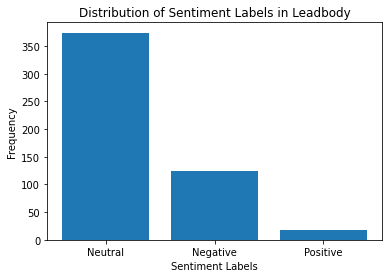

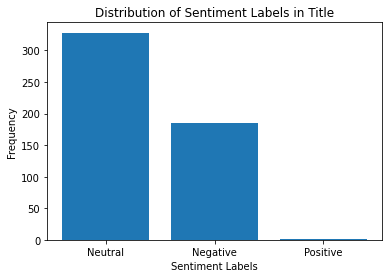

In [ ]:
# visualizing the key observations from this sentiment analysis -- the counts for the sentiments in the leadbody/headlines or titles of the NYT article


title_sentiment_counts = abortion_df['Title_sentiment'].value_counts()
sentiment_counts = abortion_df['Leadbody_sentiment'].value_counts()


plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels in Leadbody')
plt.show()

plt.bar(title_sentiment_counts.index, title_sentiment_counts.values)
plt.xlabel('Sentiment Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Labels in Title')
plt.show()

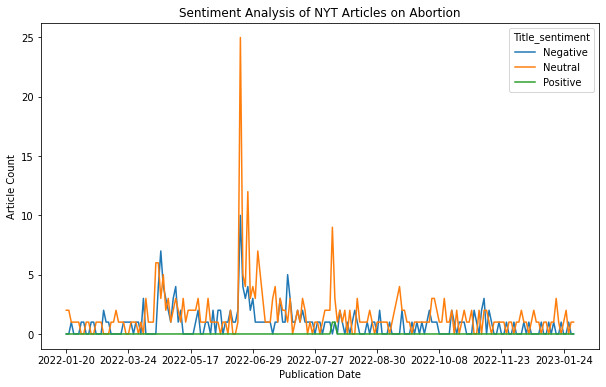

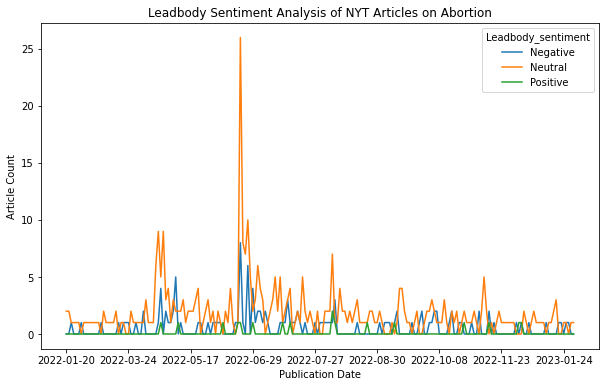

In [ ]:
import math
counts = abortion_df.groupby(["Time", "Title_sentiment"]).size().unstack(fill_value=0)
#print(counts.Negative + 1)

# plot the counts on a line chart
counts.plot(kind="line", figsize=(10, 6))

# set the chart title and axis labels
plt.title("Sentiment Analysis of NYT Articles on Abortion")
plt.xlabel("Publication Date")
plt.ylabel("Article Count")

# show the chart
plt.show()


counts = abortion_df.groupby(["Time", "Leadbody_sentiment"]).size().unstack(fill_value=0)

# plot the counts on a line chart
counts.plot(kind="line", figsize=(10, 6))

# set the chart title and axis labels
plt.title("Leadbody Sentiment Analysis of NYT Articles on Abortion")
plt.xlabel("Publication Date")
plt.ylabel("Article Count")

# show the chart
plt.show()

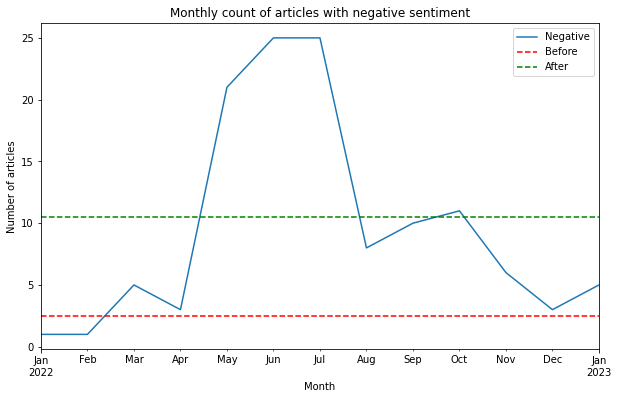

In [ ]:
# changes before 2022-06-24 to after 2022-06-24
counts.index = pd.to_datetime(counts.index)
counts_monthly = counts.resample("M").sum()

# extract the counts for the two relevant months
before_start = pd.to_datetime("2022-01")
before_end = pd.to_datetime("2022-05")
after_start = pd.to_datetime("2022-07")
after_end = pd.to_datetime("2023-1")

# compute the mean count of negative sentiment for each month
neg_before_mean = counts_monthly.loc[before_start:before_end, "Negative"].mean()
neg_after_mean = counts_monthly.loc[after_start:after_end, "Negative"].mean()

neg_before_mean,neg_after_mean

ax = counts_monthly.plot(y="Negative", legend=None, figsize=(10, 6))
ax.set_xlabel("Month")
ax.set_ylabel("Number of articles")
ax.set_title("Monthly count of articles with negative sentiment")

# add horizontal lines for the mean counts
ax.axhline(neg_before_mean, linestyle="--", color="red", label="Before")
ax.axhline(neg_after_mean, linestyle="--", color="green", label="After")

# add a legend and show the plot
ax.legend()
#plt.show()


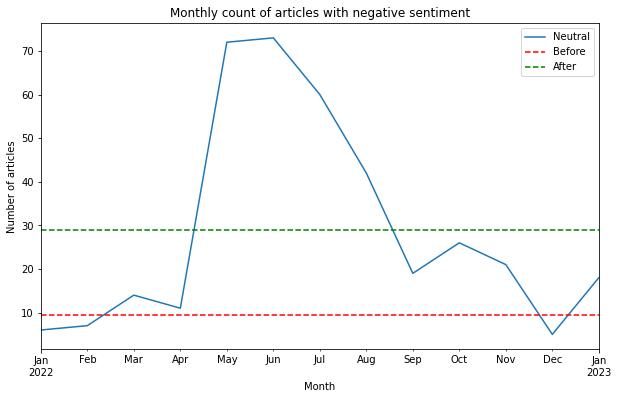

In [ ]:
counts.index = pd.to_datetime(counts.index)
counts_monthly = counts.resample("M").sum()

# extract the counts for the two relevant months
before_start = pd.to_datetime("2022-01")
before_end = pd.to_datetime("2022-05")
after_start = pd.to_datetime("2022-07")
after_end = pd.to_datetime("2023-1")

# compute the mean count of negative sentiment for each month
neg_before_mean = counts_monthly.loc[before_start:before_end, "Neutral"].mean()
neg_after_mean = counts_monthly.loc[after_start:after_end, "Neutral"].mean()

neg_before_mean,neg_after_mean

ax = counts_monthly.plot(y="Neutral", legend=None, figsize=(10, 6))
ax.set_xlabel("Month")
ax.set_ylabel("Number of articles")
ax.set_title("Monthly count of articles with negative sentiment")

# add horizontal lines for the mean counts
ax.axhline(neg_before_mean, linestyle="--", color="red", label="Before")
ax.axhline(neg_after_mean, linestyle="--", color="green", label="After")

# add a legend and show the plot
ax.legend()
#plt.show()